## DRAGON *DualFinder*: An Instance of the DRAGON CNN Architecture Specialized for Dual AGN Detection.
### Authors: Isaac Moskowitz and Jeremy Ng
### Collaborators: C. Meg Urry (PI), Aritra Ghosh. 
#### Began June 7, 2024


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
import logging
import pandas as pd
import csv
import sys
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score 
from keras import backend as K
import os
#import tensorflow_addons as tfa
import shutil
#from dual_finder import DualFinder, loadModelClass
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(tf.config.list_physical_devices())
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
from astropy.io import fits

sys.path.append("DRAGON_Dual_Finder/dual_finder/cnn/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/optimize/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/preprocess_data/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/visualize/")
from create_cnn import ModelCreator
from load_model import loadModelClass
from train_cnn import DualFinder
from extract_feature_maps import FeatureExtractor
from fits_utils import plot_dataset_sample
from process_data import make_datasets_other_bands, create_dataset
from optimize_hyperparameters import OptimizeHyperparameters
from visualize_performance import load_training_history, plot_training_progress, plot_grouped_training_progress, VisualizeOptimization

2024-06-12 09:30:44.820413: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 09:30:45.653515: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 09:30:45.653584: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 09:30:45.660200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 09:30:46.052842: I tensorflow/core/platform/cpu_feature_g

GPU is available
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18022557024980960041
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10086383616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12280638536024892085
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2024-06-12 09:31:05.457032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 9619 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [23]:
#os.chdir("~/")
#!pwd
empty_sky_filepath = "data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/"
single_AGN_filepath = "data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/"
dual_AGN_filepath = "data_preprocessing/training_datasets/dual_AGN_datasets/train_data/"
offset_AGN_filepath = 'data_preprocessing/training_datasets/offset_AGN_datasets/train_data/'
stellar_filepath = "data_preprocessing/training_datasets/stellar_dataset/train_data/"
train_data_labels, val_data_labels, test_data_labels = create_dataset(empty_sky_filepath = empty_sky_filepath,
                                                                      dual_image_filepath = dual_AGN_filepath,
                                                                      stellar_filepath = stellar_filepath,
                                                                     offset_image_filepath = offset_AGN_filepath,
                                                                     single_image_filepath = single_AGN_filepath)
train_dataset, train_labels = train_data_labels
val_dataset, val_labels = val_data_labels
test_dataset, test_labels = test_data_labels


2024-06-12 10:33:42,128 - INFO - Loading images from data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/ with label empty_sky...
100%|██████████| 9215/9215 [00:16<00:00, 553.83it/s]
9215it [00:55, 167.45it/s]
2024-06-12 10:34:55,106 - INFO - Loading images from data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/ with label single_AGN...


Loaded 36860 images with 36860 labels from data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/


100%|██████████| 2000/2000 [00:03<00:00, 571.39it/s]
2000it [00:19, 100.73it/s]
2024-06-12 10:35:19,027 - INFO - Loading images from data_preprocessing/training_datasets/dual_AGN_datasets/train_data/ with label dual_AGN...


Loaded 12000 images with 12000 labels from data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/
Length of single AGN images: 12000


100%|██████████| 14185/14185 [00:18<00:00, 760.35it/s]
2024-06-12 10:35:37,898 - INFO - expanding dims
2024-06-12 10:35:37,899 - INFO - Loading images from data_preprocessing/training_datasets/offset_AGN_datasets/train_data/ with label offset_AGN...


Loaded 14185 images with 14185 labels from data_preprocessing/training_datasets/dual_AGN_datasets/train_data/


100%|██████████| 28756/28756 [01:37<00:00, 293.95it/s]
2024-06-12 10:37:16,130 - INFO - expanding dims
2024-06-12 10:37:16,131 - INFO - Loading images from data_preprocessing/training_datasets/stellar_dataset/train_data/ with label star_AGN_align...


Loaded 28756 images with 28756 labels from data_preprocessing/training_datasets/offset_AGN_datasets/train_data/


 60%|██████    | 16999/28319 [00:25<00:18, 597.09it/s]WARNING: File may have been truncated: actual file length (38224) is smaller than the expected size (40320) [astropy.io.fits.file]
2024-06-12 10:37:41,806 - WARNING - File may have been truncated: actual file length (38224) is smaller than the expected size (40320)
100%|██████████| 28319/28319 [00:42<00:00, 659.02it/s]
2024-06-12 10:37:59,506 - INFO - expanding dims


Loaded 28319 images with 28319 labels from data_preprocessing/training_datasets/stellar_dataset/train_data/
Length of stellar images: (28319, 94, 94)
Total images: (120120, 94, 94, 1)
Total labels: (120120,)
Train_dataset: (78078, 94, 94, 1)
Train_labels: (78078,)
Val_dataset: (24024, 94, 94, 1)
Val_labels: (24024,)
Test_dataset: (18018, 94, 94, 1)
Test_labels: (18018,)


In [25]:
print(np.shape(val_dataset))
print(np.shape(val_labels))

(24024, 94, 94, 1)
(24024,)


In [ ]:
image_shape = (94,94,1)
epoch = 30
batch_size = 64
init_learning_rate = 1e-6
num_classes = 5
model_type = 'dualfinder'
importance_score = [1.0, 1.0]

dual_finder_instance = DualFinder(train_dataset, val_dataset, image_shape, train_labels, val_labels, epoch, batch_size, init_learning_rate, num_classes, model_type, importance_score, display_architecture = True)
history, dual_finder_model = dual_finder_instance.trainCNN(save_feature_maps = False)

['empty_sky' 'dual_AGN' 'offset_AGN' ... 'offset_AGN' 'star_AGN_align'
 'empty_sky']
['dual_AGN' 'empty_sky' 'star_AGN_align' ... 'single_AGN' 'offset_AGN'
 'single_AGN']
Converting to list
Converting to list
train_labels shape: (78078, 5)
val_labels shape: (24024, 5)
Unique train labels: [0. 1.]
Unique val labels: [0. 1.]
5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 94, 94, 1)         0         
                                                                 
 conv2d_35 (Conv2D)          (None, 47, 47, 64)        640       
                                                                 
 dropout_40 (Dropout)        (None, 47, 47, 64)        0         
                                                                 
 batch_normalization_35 (Ba  (None, 47, 47, 64)        256       
 tchNormalization)                                       

2024-06-12 11:14:18,148 - INFO - 'save_feature_maps' == False, NOT saving feature maps


train_images shape: (78078, 94, 94, 1)
train_labels shape: (78078, 5)
val_images shape: (24024, 94, 94, 1)
val_labels shape: (24024, 5)


In [12]:
eval_labels_encoded, _ = dual_finder_instance.encode_labels(test_labels, test_labels)
dual_finder_model.evaluate(test_dataset, eval_labels_encoded, batch_size = batch_size, verbose = 1)

['star' 'star' 'star' ... 'star' 'star' 'dual_AGN']
['star' 'star' 'star' ... 'star' 'star' 'dual_AGN']
Converting to list
Converting to list
100/100 [==============================] - 1s 5ms/step - loss: 14.2784 - accuracy: 0.8854


[14.2783784866333, 0.8853693008422852]

200/200 [==============================] - 0s 2ms/step


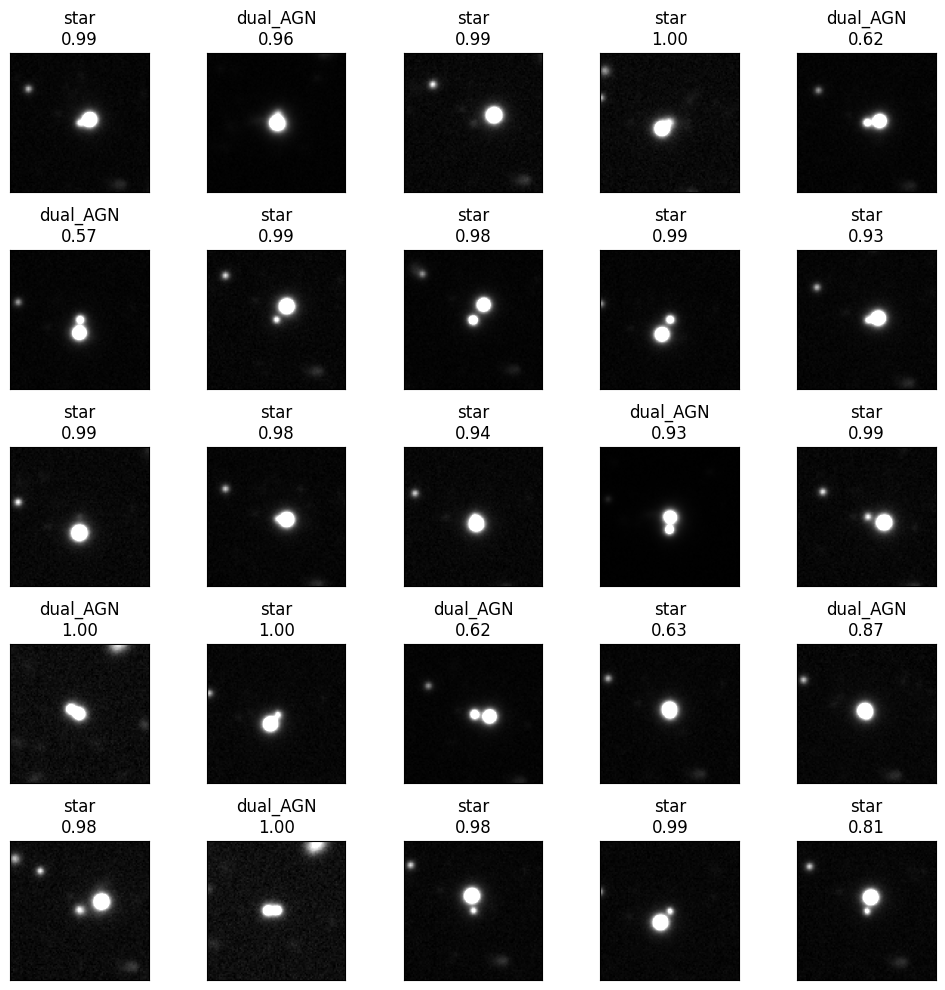

In [19]:
dual_finder_instance.predict(dual_finder_model, test_dataset)